In [31]:
import sys
sys.path.insert(0,'..')
from paths import *
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import multiprocessing as mp

from IPython.display import clear_output

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA



In [38]:
analytes_selected = pd.read_csv('../../wetlab/data/patient_selection/total_significant_compounds_model_results_using_feces_manual_selection.csv')
analytes_selected = analytes_selected[analytes_selected.selection_flag=='TRUE']


In [39]:
armss_data_lower = pd.read_csv('../../wetlab/data/patient_selection/patients_with_armss_data_lower.csv')
armss_data_higher = pd.read_csv('../../wetlab/data/patient_selection/patients_with_armss_data_higher.csv')
diet_info = pd.read_csv('../../wetlab/data/patient_selection/iMSMS Diet Restrictions.csv')

armss_data_lower.loc[:,'armms_category'] = 0
armss_data_higher.loc[:,'armms_category'] = 1

armss_data_combined = pd.concat([armss_data_lower, armss_data_higher], ignore_index=True)
armss_data_combined = armss_data_combined[['Record.ID', 'gARMSS', 'armms_category']]

armss_data_combined.head()

,Record.ID,gARMSS,armms_category
0,71501-0026,0.05,0
1,76401-0008,0.08,0
2,71701-0169,0.12,0
3,71801-0047,0.17,0
4,71801-0150,0.17,0


In [40]:
sample = "feces"

filename = SHORT_CHAIN_FATTY_ACID_DATA_FILENAME
mapping_filename = "short_chain_fatty_acid_spoke_map.csv"
file_path = os.path.join(DATA_ROOT_PATH, filename)
mapping_filepath = os.path.join(os.path.dirname(OUTPUT_PATH), mapping_filename)
data = pd.read_excel(file_path, engine='openpyxl')
data = data[data["Client Matrix"]==sample]
mapping_data = pd.read_csv(mapping_filepath)
analytes = mapping_data["name"].unique()
data.head()

,Unique Tube Label ID,Client Sample ID,Client Matrix,Sample Description,Group Name,Treatment,Gender,Age,BMI,Race / Ethnicity,Analyte,Result,Unit,Dilution Factor,LLOQ,ULOQ,Analysis Comment
0,FB06341898,71801-0010,feces,Fecal sample,MS,Off,F,50.0,18.645344,Caucasian/Hispanic,2-Methylbutyric acid,159.251,µg/g,1,5,2000,NaN
1,FB06341896,71801-0027,feces,Fecal sample,MS,Treated,M,29.0,23.038752,Caucasian/Hispanic,2-Methylbutyric acid,171.655,µg/g,1,5,2000,NaN
2,FB06341882,71801-0022,feces,Fecal sample,MS,Treated,F,33.0,17.474717,Caucasian/Hispanic,2-Methylbutyric acid,26.897,µg/g,1,5,2000,NaN
3,FB06341906,71801-0017,feces,Fecal sample,MS,Treated,F,53.0,25.721032,Caucasian/Hispanic,2-Methylbutyric acid,116.243,µg/g,1,5,2000,NaN
4,FB06341902,71802-0027,feces,Fecal sample,Control,Control,F,32.0,18.426534,Caucasian/Hispanic,2-Methylbutyric acid,48.814,µg/g,1,5,2000,NaN


In [41]:
patient_data_targeted = data[data['Client Sample ID'].isin(armss_data_combined['Record.ID'])]

targeted_analytes_selected = analytes_selected[(analytes_selected.selection_flag=='TRUE') & (analytes_selected.analyte_type == 'targeted')]
patient_data_targeted_selected_analytes = patient_data_targeted[patient_data_targeted['Analyte'].isin(targeted_analytes_selected.analyte_name)]

target_analytes = patient_data_targeted_selected_analytes.Analyte.unique()
patient_ids = patient_data_targeted_selected_analytes['Client Sample ID'].unique()



In [42]:
all_patient_feature = []
for patient_id in patient_ids:
    extracted_data = patient_data_targeted_selected_analytes[patient_data_targeted_selected_analytes['Client Sample ID']==patient_id]
    patient_feature = []
    for target_analyte in target_analytes:         
        patient_feature.append(extracted_data[extracted_data['Analyte']==target_analyte]['Result'])
    all_patient_feature.append(patient_feature)
        
patient_feature_targeted = np.array(all_patient_feature).reshape(len(patient_ids),len(target_analytes))
patient_feature_targeted_df = pd.DataFrame(patient_feature_targeted, columns=list(target_analytes))
patient_feature_targeted_df.loc[:,'patient_id'] = patient_ids
patient_feature_targeted_df

,2-Methylbutyric acid,Acetic acid,Isobutyric acid,Isovaleric acid,patient_id
0,53.728,3433.855,52.407,46.708,71801-0006
1,178.222,3392.246,212.504,231.412,71701-0041
2,71.101,5719.594,90.683,69.279,71801-0004
3,86.902,1303.278,122.308,124.457,71401-0026
4,209.199,1900.786,256.838,269.748,71501-0039
...,...,...,...,...,...
95,71.773,2285.885,110.147,96.813,71401-0204
96,105.498,1913.701,125.983,137.323,71401-0230
97,89.344,1450.422,123.191,128.759,71401-0254
98,216.407,2677.758,234.675,247.166,71401-0255


In [43]:
if sample == "serum":
    filename = GLOBAL_SERUM_DATA_FILENAME
else:
    filename = GLOBAL_STOOL_DATA_FILENAME
    

file_path = os.path.join(DATA_ROOT_PATH, filename)

sheet_name = ["Chemical Annotation", "Sample Meta Data", "Log Transformed Data"]

analyte_metadata = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[0])
patient_metadata = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[1])
data = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[2])

patient_metadata.loc[:, "site_code"] = patient_metadata["CLIENT_SAMPLE_ID"].apply(lambda x:x[0:3])

global_metabolomics_compound_spoke_map = pd.read_csv(os.path.join(os.path.dirname(OUTPUT_PATH), "global_metabolomics_compound_spoke_map.csv"))

analyte_columns = list(data.columns)
analyte_columns.remove("PARENT_SAMPLE_NAME")

analyte_columns_selected = global_metabolomics_compound_spoke_map[global_metabolomics_compound_spoke_map.CHEM_ID.isin(analyte_columns)]["CHEM_ID"].unique()

data_with_analyte_columns_selected = data[["PARENT_SAMPLE_NAME"]+list(analyte_columns_selected)]
selected_metadata_columns = ["PARENT_SAMPLE_NAME", "CLIENT_IDENTIFIER", "GROUP_NAME", "AGE", "BMI", "GENDER", "CLIENT_SAMPLE_ID", "CLIENT_MATRIX", "TREATMENT", "SAMPLE_AMOUNT_UNITS"]
patient_metadata_selected_columns = patient_metadata[selected_metadata_columns]
patient_metadata_selected_columns.loc[:, 'house'] = (patient_metadata_selected_columns['CLIENT_SAMPLE_ID'].str[:3] + patient_metadata_selected_columns['CLIENT_SAMPLE_ID'].str[-4:])
patient_metadata_selected_columns.loc[:, 'site'] = patient_metadata_selected_columns.loc[:, 'CLIENT_SAMPLE_ID'].str[:3]

le = LabelEncoder()
patient_metadata_selected_columns.loc[:, 'Gender_label'] = le.fit_transform(patient_metadata_selected_columns['GENDER'])

data_with_patient_metadata = pd.merge(data_with_analyte_columns_selected, patient_metadata_selected_columns, on="PARENT_SAMPLE_NAME")

selected_metadata_columns.append('Gender_label')

clear_output()

data_with_patient_metadata = data_with_patient_metadata[data_with_patient_metadata.CLIENT_SAMPLE_ID.isin(patient_ids)]



In [44]:
data_with_patient_metadata

,PARENT_SAMPLE_NAME,35,50,62,93,98,111,112,144,158,...,AGE,BMI,GENDER,CLIENT_SAMPLE_ID,CLIENT_MATRIX,TREATMENT,SAMPLE_AMOUNT_UNITS,house,site,Gender_label
29,UCSF-07787,-0.226544,-1.122074,-3.918197,-0.392817,-3.727361,-1.543398,-0.603480,-0.280889,-2.241044,...,47.0,26.153363,M,71701-0229,feces,Off,ug,7170229,717,1
32,UCSF-07790,0.178154,-0.592624,-3.918197,0.041937,1.422294,-1.543398,0.777008,-0.725859,-2.241044,...,29.0,19.919395,F,71501-0024,feces,Off,ug,7150024,715,0
34,UCSF-07792,-0.558773,-1.058159,-3.918197,-0.701228,-1.373445,-1.543398,1.210952,-0.552114,-2.241044,...,54.0,27.624914,F,71701-0010,feces,Off,ug,7170010,717,0
35,UCSF-07793,-0.458945,-1.936099,0.136307,-0.316882,1.106109,-1.543398,-0.085426,0.046193,-2.241044,...,73.0,29.868536,F,71401-0122,feces,Off,ug,7140122,714,0
69,UCSF-07827,0.002786,-0.721220,-2.116110,-0.374604,1.025983,-1.543398,1.333489,-0.287259,-2.241044,...,61.0,24.973985,F,71701-0247,feces,Off,ug,7170247,717,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,UCSF-08752,-0.106155,-0.602941,0.395569,-0.411303,-1.639334,-1.543398,0.047739,0.639264,-2.241044,...,63.0,26.571482,M,71401-0204,feces,Off,ug,7140204,714,1
995,UCSF-08753,-0.571121,-1.527935,-1.388333,-0.715152,0.888845,0.931591,0.043707,0.050014,-2.241044,...,37.0,20.079601,F,71701-0122,feces,Off,ug,7170122,717,0
996,UCSF-08754,-2.130696,-3.084500,-3.918197,-2.229978,1.455566,-0.119768,2.458673,-0.965316,-2.241044,...,54.0,19.312952,F,71801-0150,feces,Off,ug,7180150,718,0
998,UCSF-08756,-0.044102,-0.727946,-3.918197,-1.015157,-1.069690,-1.543398,-0.368464,-0.733178,-2.241044,...,42.0,20.597742,F,71601-0171,feces,Off,ug,7160171,716,0


In [45]:
untargeted_analytes_selected = analytes_selected[(analytes_selected.selection_flag=='TRUE') & (analytes_selected.analyte_type == 'untargeted')]

selected_untargeted_analytes_column_ids = list(analyte_metadata[analyte_metadata.CHEMICAL_NAME.isin(untargeted_analytes_selected.analyte_name)].CHEM_ID.values)



In [46]:
patient_data_untargeted = data_with_patient_metadata[data_with_patient_metadata['CLIENT_SAMPLE_ID'].isin(patient_ids)]
patient_feature_untargeted_df = patient_data_untargeted[selected_untargeted_analytes_column_ids+['CLIENT_SAMPLE_ID']]



In [47]:
patient_feature_df = pd.merge(patient_feature_targeted_df, patient_feature_untargeted_df, left_on='patient_id', right_on='CLIENT_SAMPLE_ID').drop('patient_id', axis=1)

patient_feature_df = pd.merge(patient_feature_df, armss_data_combined, left_on='CLIENT_SAMPLE_ID', right_on='Record.ID').drop('Record.ID', axis=1)

patient_feature_df.head()


,2-Methylbutyric acid,Acetic acid,Isobutyric acid,Isovaleric acid,35,50,62,93,112,189,...,100016038,100019968,100019982,100020272,100021372,100022041,100022120,CLIENT_SAMPLE_ID,gARMSS,armms_category
0,53.728,3433.855,52.407,46.708,0.257417,3.333464,1.631959,0.328936,-0.129403,0.821315,...,1.613581,-0.424104,-2.824937,-2.538195,2.043077,-0.615716,0.812641,71801-0006,0.37,0
1,178.222,3392.246,212.504,231.412,-0.450607,-0.514487,-1.401265,-0.203660,-0.912769,0.195296,...,0.768301,0.508428,-0.250536,-2.538195,-1.428522,1.619667,-1.351363,71701-0041,6.72,1
2,71.101,5719.594,90.683,69.279,0.048915,1.398039,1.227168,1.211351,-0.789701,0.842328,...,2.905466,0.759874,1.467064,-2.538195,-0.678323,-0.057628,0.659725,71801-0004,1.62,0
3,86.902,1303.278,122.308,124.457,0.172592,1.030814,-3.918197,-0.895566,-0.691552,-0.225630,...,-1.987018,0.288505,-2.824937,-2.538195,2.436339,0.433656,-0.025812,71401-0026,9.59,1
4,209.199,1900.786,256.838,269.748,-0.052102,-1.263813,0.149758,-1.169163,-1.028374,-1.095294,...,-1.325474,-0.713408,-0.066710,-2.538195,-1.964469,-3.016725,0.453940,71501-0039,8.78,1


In [48]:

patient_feature_array = patient_feature_df.drop(['CLIENT_SAMPLE_ID', 'gARMSS', 'armms_category'], axis=1).to_numpy()


In [49]:
mean = np.mean(patient_feature_array, axis=0)
std_dev = np.std(patient_feature_array, axis=0)


patient_feature_array_normalized = (patient_feature_array - mean) / std_dev



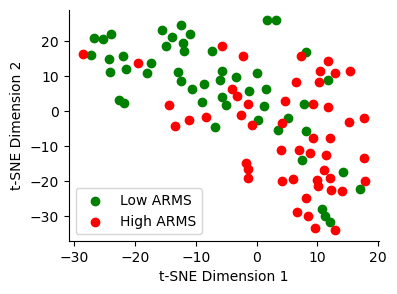

In [50]:
from sklearn.manifold import TSNE

# Assuming standardized_matrix contains your z-score standardized matrix
# Assuming patient_feature_df contains your dataframe

# Extract 'armms_category' column
armms_category = patient_feature_df['armms_category']

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=8, random_state=7)
tsne_results = tsne.fit_transform(patient_feature_array_normalized)

# Plot t-SNE embedding with colors based on 'armms_category'
fig = plt.figure(figsize=(4,3))
plt.scatter(tsne_results[armms_category == 0, 0], tsne_results[armms_category == 0, 1], color='green', alpha=1, label='Low ARMS')
plt.scatter(tsne_results[armms_category == 1, 0], tsne_results[armms_category == 1, 1], color='red', alpha=1, label='High ARMS')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
# plt.title('t-SNE Plot of Z-score Normalized Matrix')
plt.legend(title='armms_category')
plt.legend(title='')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.grid(True)
plt.show()


# fig.savefig('../../wetlab/data/patient_selection/selected_analytes_based_patient_profile_tsne.svg', format='svg', bbox_inches='tight')
# fig.savefig('../../wetlab/data/patient_selection/selected_analytes_based_patient_profile_tsne.png', format='png', bbox_inches='tight')


In [21]:
tsne_df = patient_feature_df.copy()
tsne_df.loc[:,'tsne1'] = tsne_results[:,0]
tsne_df.loc[:,'tsne2'] = tsne_results[:,1]
tsne_df.loc[tsne_df.armms_category==0, 'armms_category']='Lower ARMSS'
tsne_df.loc[tsne_df.armms_category==1, 'armms_category']='Higher ARMSS'

tsne_df.head()

tsne_df = tsne_df[tsne_df.CLIENT_SAMPLE_ID.str.startswith('714')]
tsne_df.columns

Index(['2-Methylbutyric acid',          'Acetic acid',      'Isobutyric acid',
            'Isovaleric acid',                     35,                     50,
                           62,                     93,                    112,
                          189,
       ...
                    100019982,              100020272,              100021372,
                    100022041,              100022120,     'CLIENT_SAMPLE_ID',
                     'gARMSS',       'armms_category',                'tsne1',
                      'tsne2'],
      dtype='object', length=174)

In [29]:
armms_category = tsne_df['armms_category']

# Apply t-SNE
# tsne = TSNE(n_components=2, perplexity=8, random_state=7)
# tsne_results = tsne.fit_transform(patient_feature_array_normalized)

tsne_results = tsne_df[['tsne1', 'tsne2']].to_numpy()
tsne_results[armms_category == 'Lower ARMSS', 0]


array([-12.188417  , -12.364321  , -21.965876  , -10.63882   ,
        -5.9896827 ,   1.791718  ,   0.13944519], dtype=float32)

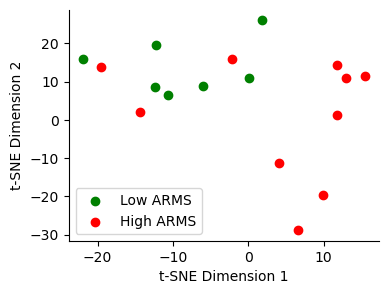

In [30]:


# Assuming standardized_matrix contains your z-score standardized matrix
# Assuming patient_feature_df contains your dataframe

# Extract 'armms_category' column
armms_category = tsne_df['armms_category']

# Apply t-SNE
# tsne = TSNE(n_components=2, perplexity=8, random_state=7)
# tsne_results = tsne.fit_transform(patient_feature_array_normalized)

tsne_results = tsne_df[['tsne1', 'tsne2']].to_numpy()

# Plot t-SNE embedding with colors based on 'armms_category'
fig = plt.figure(figsize=(4,3))
plt.scatter(tsne_results[armms_category == 'Lower ARMSS', 0], tsne_results[armms_category == 'Lower ARMSS', 1], color='green', alpha=1, label='Low ARMS')
plt.scatter(tsne_results[armms_category == 'Higher ARMSS', 0], tsne_results[armms_category == 'Higher ARMSS', 1], color='red', alpha=1, label='High ARMS')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
# plt.title('t-SNE Plot of Z-score Normalized Matrix')
plt.legend(title='armms_category')
plt.legend(title='')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.grid(True)
plt.show()


# fig.savefig('../../wetlab/data/patient_selection/selected_analytes_based_patient_profile_tsne.svg', format='svg', bbox_inches='tight')
# fig.savefig('../../wetlab/data/patient_selection/selected_analytes_based_patient_profile_tsne.png', format='png', bbox_inches='tight')


In [186]:
tsne_df.to_csv('../../wetlab/data/patient_selection/patient_profile.csv', index=False)


In [157]:
from scipy.spatial.distance import cdist

l1_distance_matrix = cdist(patient_feature_array_normalized, patient_feature_array_normalized, 'cityblock')

# Check the size of the distance matrix
print("Size of L1 distance matrix:", l1_distance_matrix.shape)

Size of L1 distance matrix: (100, 100)


In [167]:
np.where(l1_distance_matrix==l1_distance_matrix.max())

print(patient_feature_df.iloc[45].CLIENT_SAMPLE_ID)
print(patient_feature_df.iloc[45].armms_category)


71701-0177
1


In [168]:
print(patient_feature_df.iloc[50].CLIENT_SAMPLE_ID)
print(patient_feature_df.iloc[50].armms_category)


71501-0047
0


In [ ]:
# armms_category = patient_feature_df['armms_category']

# # Apply PCA


# pca = PCA(n_components=2, whiten=True)
# principal_components = pca.fit_transform(patient_feature_array_normalized)

# # Plot the first two dimensions with color based on 'armms_category'
# plt.figure(figsize=(5,4))
# plt.scatter(principal_components[armms_category == 0, 0], principal_components[armms_category == 0, 1], color='green', alpha=1, label='Low ARMSS')
# plt.scatter(principal_components[armms_category == 1, 0], principal_components[armms_category == 1, 1], color='red', alpha=1, label='High ARMSS')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# # plt.title('PCA Plot of Z-score Normalized Matrix')
# plt.legend(title='')
# plt.grid(True)
# plt.show()